In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

c:\Users\Sohan M\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [3]:
train_dir = "./concrete_cracked_images/train/"
test_dir = "./concrete_cracked_images/test/"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create starter transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=90),
    
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           

# Create datasets

train_dataset = torchvision.datasets.ImageFolder(root = train_dir, transform = train_transform)


In [4]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 28718
    Root location: ./concrete_cracked_images/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
test_dataset = torchvision.datasets.ImageFolder(root = test_dir, transform = test_transform)

In [6]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 11282
    Root location: ./concrete_cracked_images/test/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
classes = ("negative", "positive")


In [8]:
from torch import conv2d, max_pool2d
from torch.nn import Dropout, Linear
from torch.nn.modules import MaxPool2d, ReLU, linear, padding
from torch.nn.modules.pooling import MaxPool3d


class AlexNet(nn.Module):
    def __init__(self,n_classes) :
        super(AlexNet,self).__init__()
        
        self.featuresex = nn.Sequential(
            nn.Conv2d(in_channels= 3, out_channels= 64,kernel_size = (11,11) ,stride= (3,3), padding = (2,2)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 3, stride=2, padding = 0, dilation=1, ceil_mode=False),
            nn.Conv2d(in_channels= 64, out_channels= 192, kernel_size= (5,5), stride=(2,2), padding = (1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 3, stride=2, padding = 0, dilation=1, ceil_mode=False),
            nn.Conv2d(in_channels= 192, out_channels= 384, kernel_size=(3,3), stride=(1,1),padding =(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels= 384, out_channels= 256, kernel_size=(3,3), stride=(1,1),padding =(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels= 256, out_channels= 256 , kernel_size=(3,3), stride=(1,1),padding =(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 3, stride=2, padding = 0, dilation=1, ceil_mode=False),
            nn.AdaptiveAvgPool2d(output_size=(6,6))
            
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace= False),
            nn.Linear(in_features= 9216, out_features=4096, bias = True),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features= 4096, out_features= 1024, bias = True),
            nn.ReLU(),
            nn.Linear(in_features= 1024, out_features= 2, bias = True)

            
        )
    def forward(self, x):
        x = self.featuresex(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        # probs = F.softmax(logits, dim=1)
        return logits
        
     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


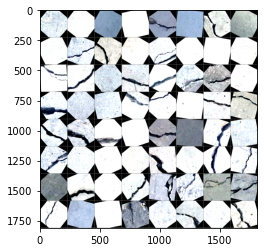

positive positive positive positive


In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [10]:
model = AlexNet(2).to(device)

In [11]:
import torch.optim as optim

In [12]:
torch.manual_seed(99)

optimizer = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

In [13]:
def train(trainloader,model):
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            

            # zero the parameter gradients
            optimizer.zero_grad()
            

            # forward + backward + optimize
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training of AlexNet')
    
    

In [14]:
from torchvision.transforms import ToTensor

In [ ]:
train(train_dataloader,model)

In [15]:


correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / 708))

Accuracy of the network on the 10000 test images: 0 %


KeyboardInterrupt: 

AttributeError: 'ImageFolder' object has no attribute 'data'

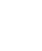

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(test_dataset[index][0].unsqueeze(0))
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('AlexNet - predictions')

In [ ]:
test_dataset.